In [31]:
import obspy
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta, coincidence_trigger
from obspy_local.obspy_local.io.segy.core import _read_segy
import h5py
from scipy.signal import spectrogram
import scipy
import numpy as np
import glob
import matplotlib. pyplot as plt
import matplotlib.dates as mdates
import datetime as datetime
import pickle

In [ ]:
'''

Plot the entire dataset on a few a different frequency bands at a few channels

'''

# choose which channels to plot
channels = [331,431,531,631,731,831,931,1031]

# choose time limits (we want to exclude all the anthropoenic noise near the start)
starttime = obspy.UTCDateTime(2019,7,6,12)
endtime = obspy.UTCDateTime(2019,7,9)

# set frequency bins
freq_bins = [0.001,0.01,0.1,1,10,100,500]

# get list of all continuous channel files
path = "/1-fnp/pnwstore1/p-wd05/greenland/data/channel/"
files = []
for channel in channels:
    files.append(path+"channel_"+str(channel)+".mseed")

# iterate through input files
for f in files:
    
    # read file
    st = obspy.read(f)
    
    # trim to time limits
    st.trim(starttime=starttime,endtime=endtime)
    
    # filter on a few bands and plot
    for b in range(len(freq_bins)-1):

        # filter the data
        st_filt = st.copy()
        st_filt.filter("bandpass",freqmin=freq_bins[b],freqmax=freq_bins[b+1])
        
        # semi-intelligently auto-limit the y axis by fin
        distance = 86400/2*1000
        peak_indices = scipy.signal.find_peaks(st_filt[0].data,distance=distance)[0]
        peaks = st_filt[0].data[peak_indices]
        ymax = np.partition(peaks.flatten(), -3)[-3]

        # make a plot
        channel = f.split("_")[1].split(".")[0]
        fname = "/home/solinger/continuous/channel_"+channel+"_"+str(freq_bins[b])+"-"+str(freq_bins[b+1])+"_Hz.png"
        fig = st_filt[0].plot(dpi=100,qdp="off",size=(1500,600),handle=True)
        ax = fig.axes[0]
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d \n %H:%M'))
        ax.set_xticks([18083.5, 18083.75, 18084. ,  18084.25, 18084.5, 18084.75,  18085. , 18085.25, 18085.5])
        ax.set_ylim([-ymax,ymax])
        plt.title("Channel "+channel+" ("+str(freq_bins[b])+"-"+str(freq_bins[b+1])+" Hz)")
        plt.savefig(fname)

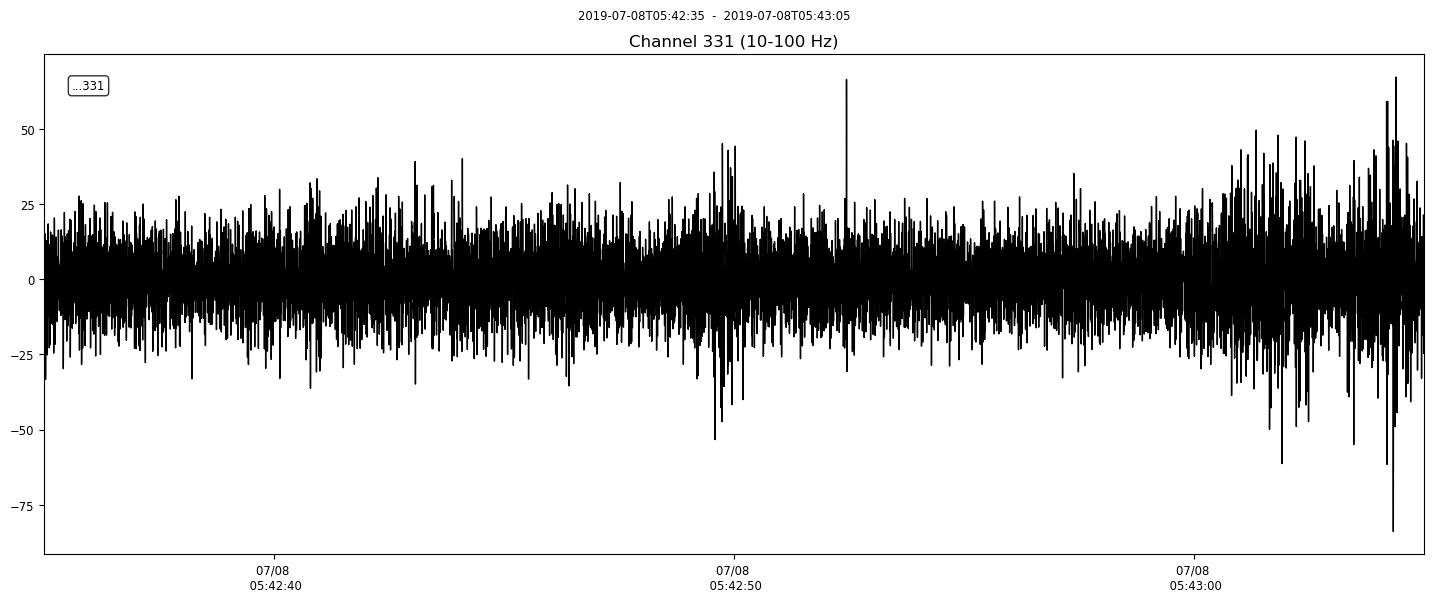

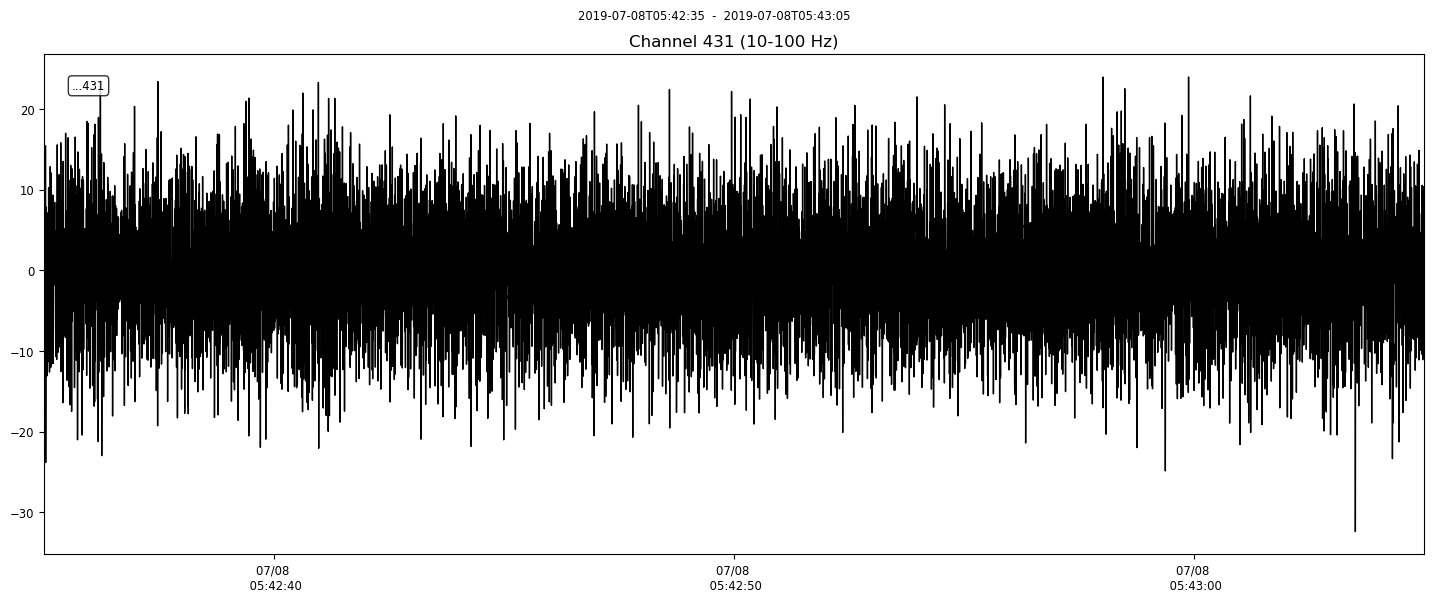

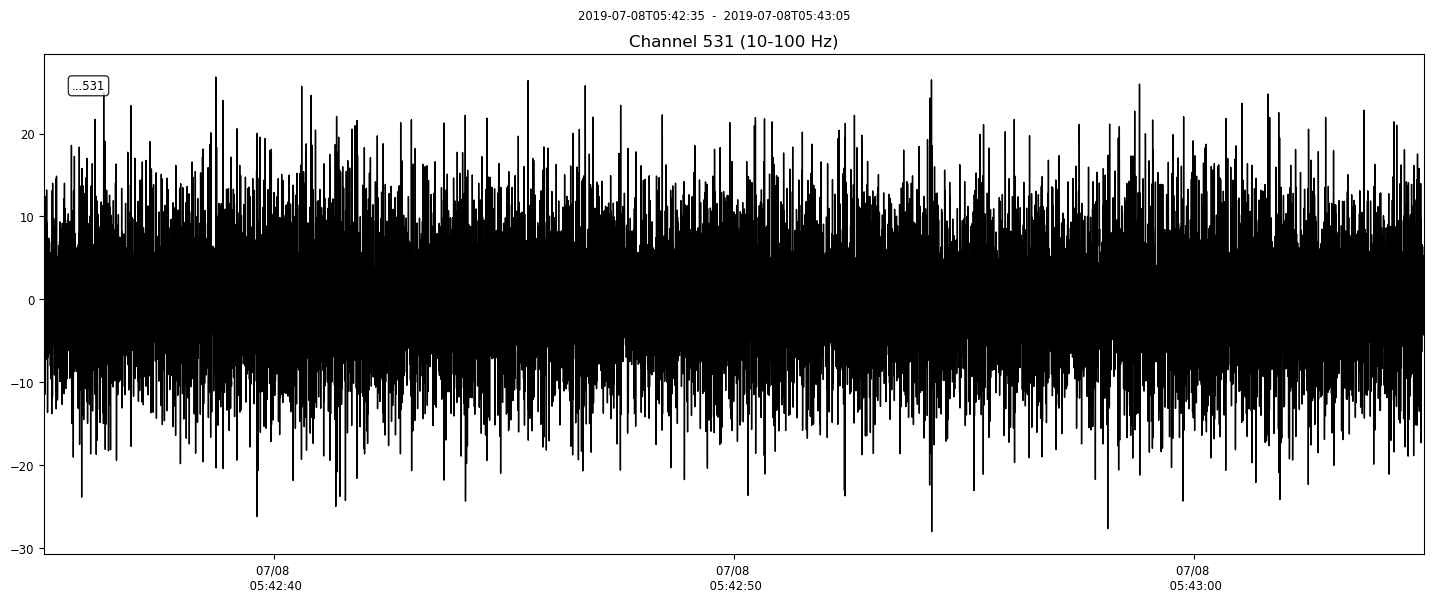

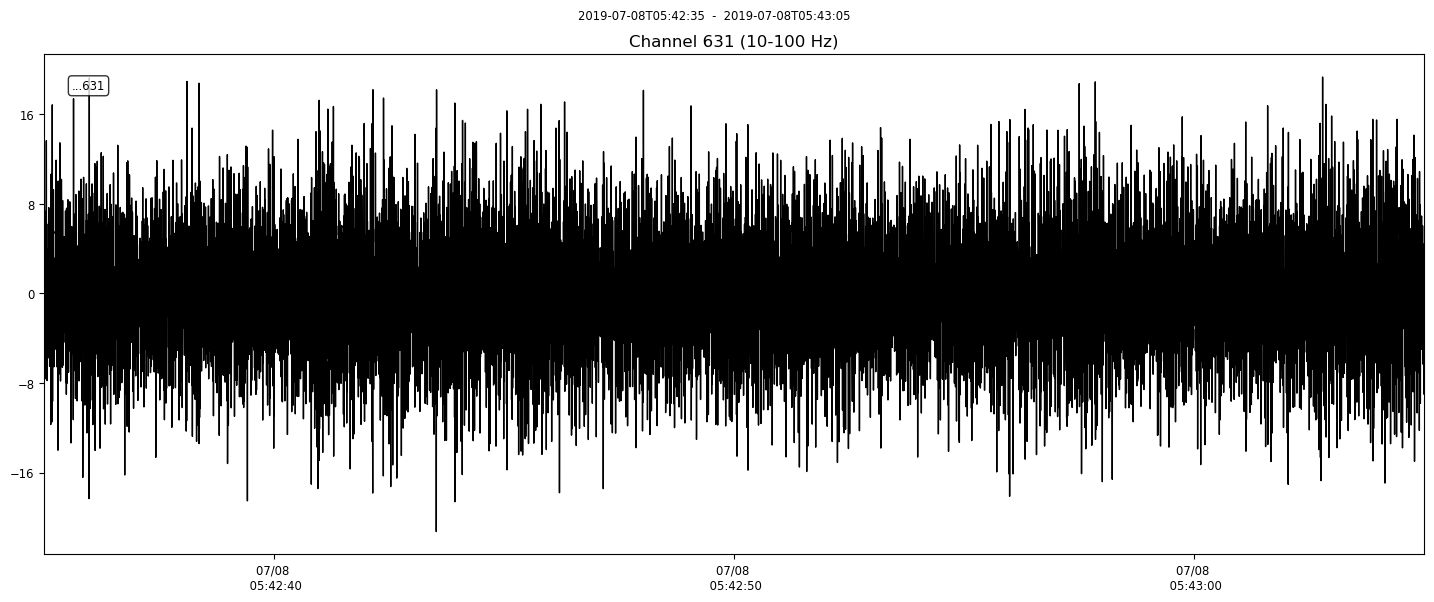

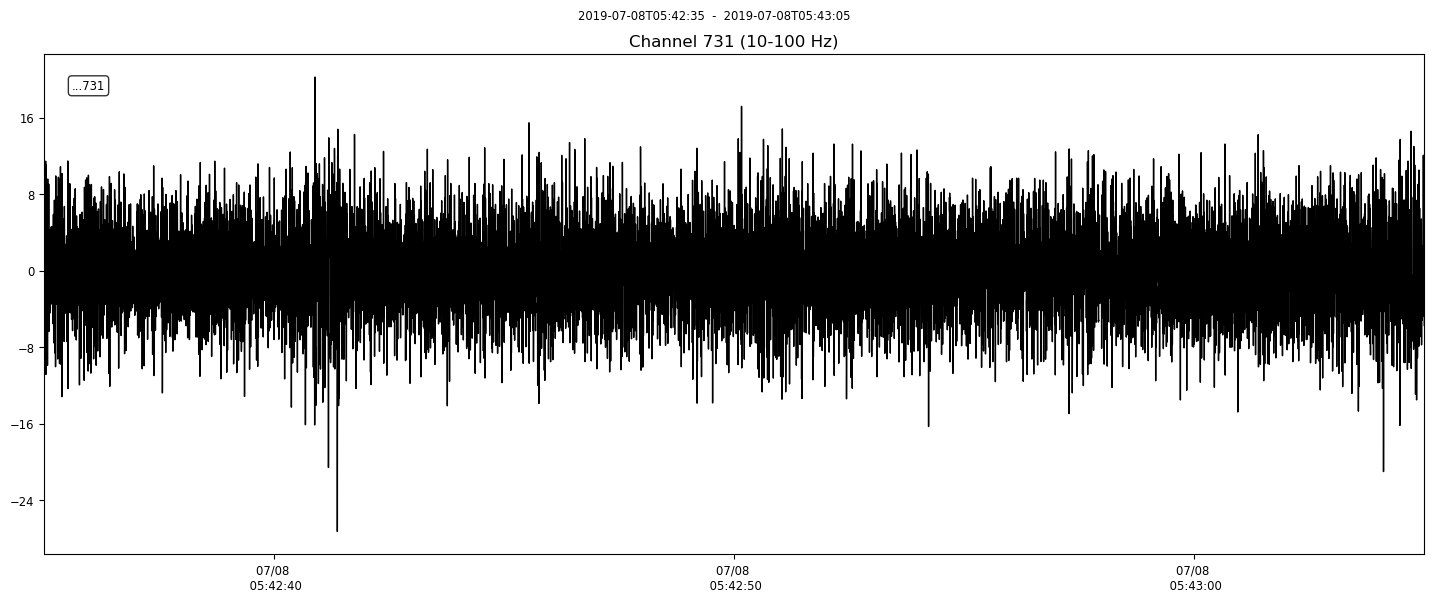

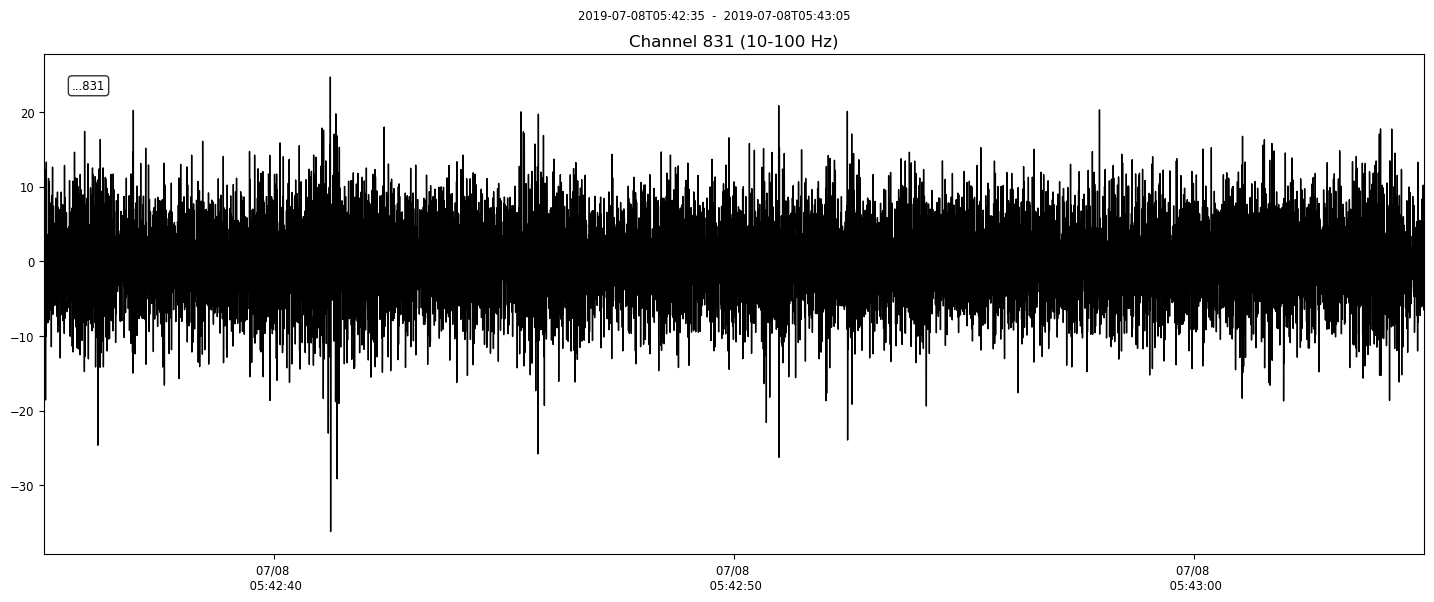

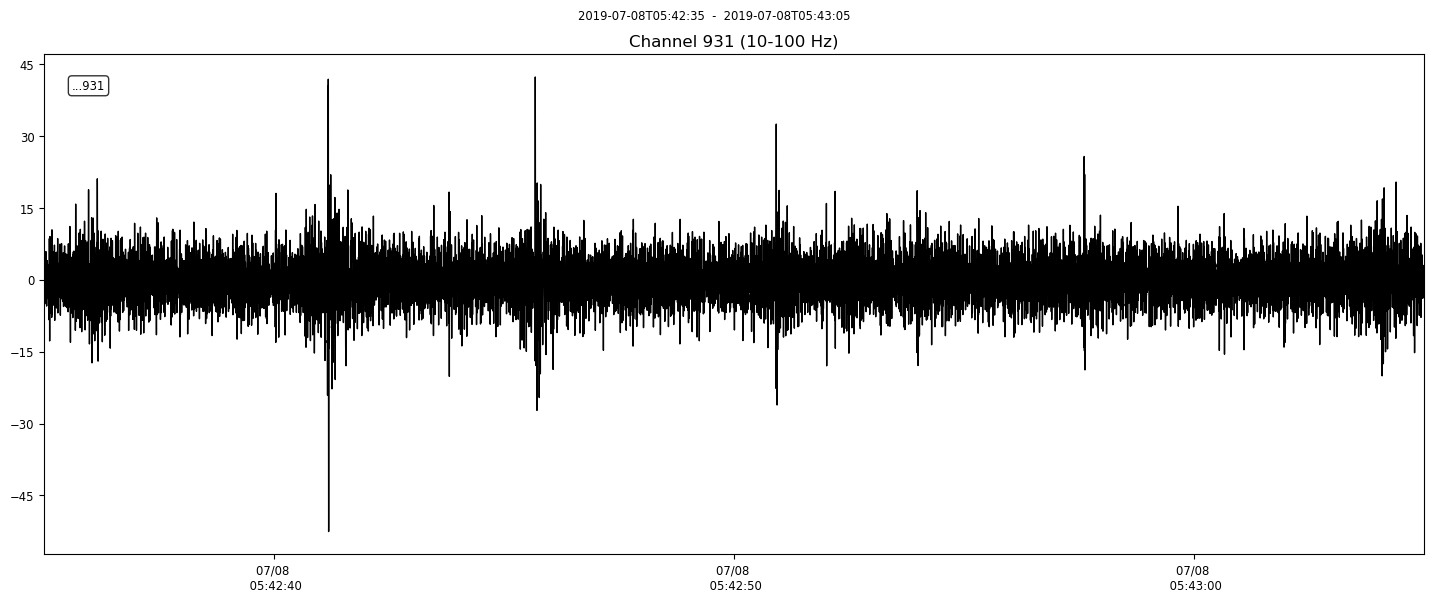

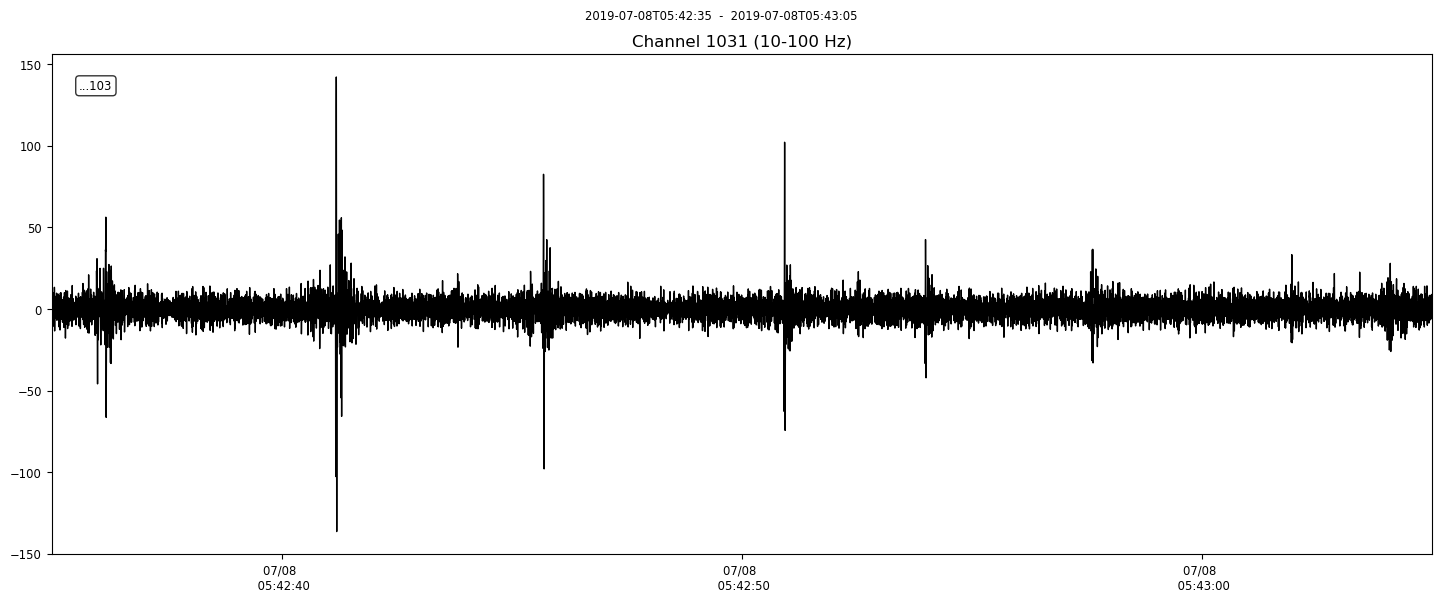

In [116]:
'''

Investigate the icequakes at 10-100Hz

'''

# choose which channels to plot
channels = [331,431,531,631,731,831,931,1031]

# set time limits
# starttime = obspy.UTCDateTime(2019,7,8,4,45)
# endtime = obspy.UTCDateTime(2019,7,8,6,30)
starttime = obspy.UTCDateTime(2019,7,8,5,42,35)
endtime = obspy.UTCDateTime(2019,7,8,5,43,5)

# set frequency band
freq = [10,100]

# get list of all continuous channel files
path = "/1-fnp/pnwstore1/p-wd05/greenland/data/channel/"
files = []
for channel in channels:
    files.append(path+"channel_"+str(channel)+".mseed")
    

# iterate through input files
for f in files:
    
    # read file
    st = obspy.read(f)
    
    # trim to time limits
    st.trim(starttime=starttime,endtime=endtime)

    # filter the data
    st_filt = st.copy()
    st_filt.filter("bandpass",freqmin=freq[0],freqmax=freq[1])

    # semi-intelligently auto-limit the y axis by fin
#     distance = 3600*1000
#     peak_indices = scipy.signal.find_peaks(st_filt[0].data,distance=distance)[0]
#     peaks = st_filt[0].data[peak_indices]
#     ymax = np.partition(peaks.flatten(), -3)[-3]

    # make a plot
    channel = f.split("_")[1].split(".")[0]
    fname = "/home/solinger/continuous/channel_"+channel+"_"+str(freq[0])+"-"+str(freq[1])+"_Hz_zoom.png"
    fig = st_filt[0].plot(dpi=100,qdp="off",size=(1500,600),handle=True)
    ax = fig.axes[0]
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d \n %H:%M:%S'))
    #ax.set_ylim([-ymax,ymax])
    plt.title("Channel "+channel+" ("+str(freq[0])+"-"+str(freq[1])+" Hz)")
    plt.savefig(fname)

Somewhere around...7740


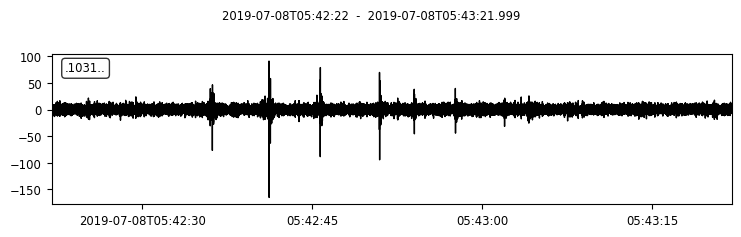

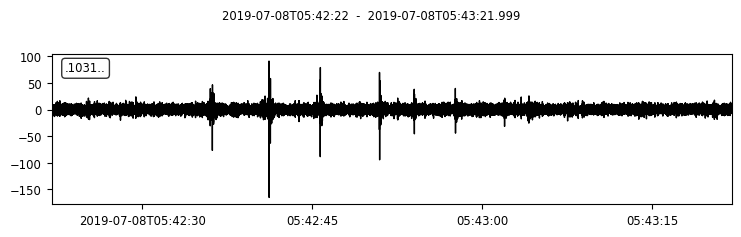

In [434]:
'''

Find the 30s file that contains the above

'''

# choose frequency band
freq = [20,100]

# list all the natively 1khz files
path_1khz = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/1kHz/*"
path_resampled = "/1-fnp/pnwstore1/p-wd05/greenland/data/resampled/*"
files_1khz = glob.glob(path_1khz)

# list all the resamopled 1khz files
files_resampled = glob.glob(path_resampled)

# combine and sort
files_1khz_all = files_1khz + files_resampled
files_1khz_all.sort()

# calculate (approximately) which file it should be
win_start = obspy.UTCDateTime(2019,7,8,5,42,35)
files_start = _read_segy(files_1khz_all[1])[0].stats.starttime
file_number = round((win_start - files_start) / 30)
print("Somewhere around..."+str(file_number))

# read the relevant files, filter, and combine
st1 = _read_segy(files_1khz_all[7346])
st2 = _read_segy(files_1khz_all[7347])
st1.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
st2.filter("bandpass",freqmin=freq[0],freqmax=freq[1])

# add some helpful metadata
for s in [st1,st2]:
    for i in range(len(s)):
        s[i].stats.station = str(i)
st = st1 + st2

# merge traces (note that this reorders them based on station code, so you MUST use st.select(), not naive indexing)
st.merge()

# plot to verify we're in the right time period
st.select(station="1031").plot()

In [435]:
'''

Get moveout data for the entire window

'''

# select channels of interest
channels = range(331,1361)

# make container
npts = st[0].stats.npts
data = np.zeros((npts,len(channels)))

# fill container with data from each desired channel
for channel in channels:
    data[:,channel-channels[0]] = st.select(station=str(channel))[0].data

In [442]:
'''

Get moveout data for a single event

'''

# set time limits and trim
starttime = obspy.UTCDateTime(2019,7,8,5,42,41)
endtime = obspy.UTCDateTime(2019,7,8,5,42,42)
st_event = st.copy().trim(starttime=starttime,endtime=endtime)

# select channels of interest
channels = range(331,1361)

# make container
npts = st_event[0].stats.npts
event_data = np.zeros((npts,len(channels)))

# fill container with data from each desired channel
for channel in channels:
    event_data[:,channel-channels[0]] = st_event.select(station=str(channel))[0].data

In [443]:
def plot_moveout(data,st,channels):
    t = st[0].times()
    spacing = 1.017
    datetimes = [st[0].stats.starttime.datetime+datetime.timedelta(seconds=sec) for sec in t]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.pcolormesh(datetimes,(np.array(channels)-channels[0])*spacing,np.transpose(data),cmap='gray',vmin=-50,vmax=50)
    plt.gca().invert_yaxis()
    ax.set_ylabel("Depth (m)")
    ax.set_xlabel("Time (s)")
    return ax

/tmp/ipykernel_505175/1843022313.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(datetimes,(np.array(channels)-channels[0])*spacing,np.transpose(data),cmap='gray',vmin=-50,vmax=50)


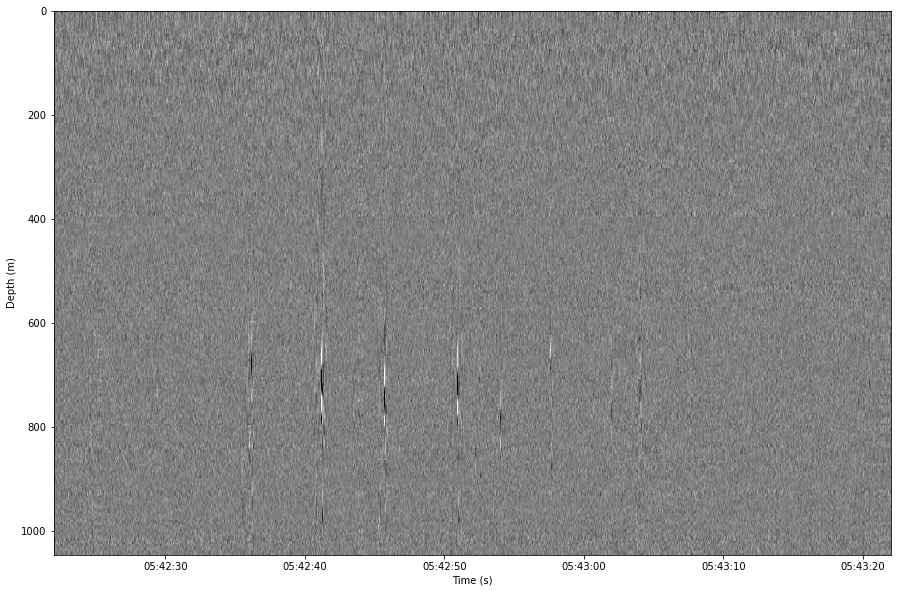

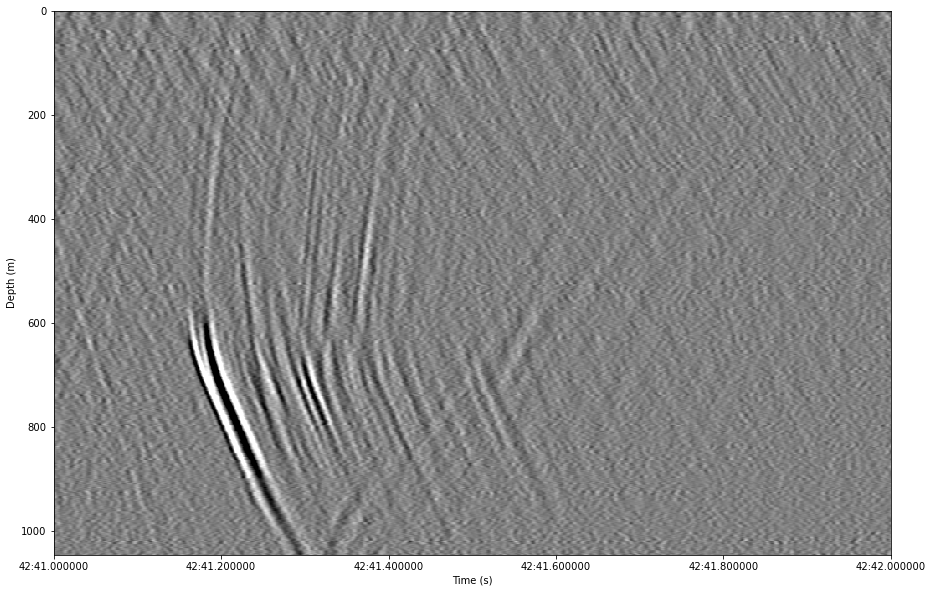

In [444]:
'''

Plot the moveouts

'''

plot_moveout(data,st,channels)
ax = plot_moveout(event_data,st_event,channels)
#ax.vlines(trigger_times,ymin=0,ymax=channels[-1]-channels[0],colors="r",linestyles="--")

In [420]:
'''

Design some code for getting the earliest arrival (and therefore the apparent depth)

'''

# set frequency band
freq = [10,50]

# list all the natively 1khz files
path_1khz = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/1kHz/*"
path_resampled = "/1-fnp/pnwstore1/p-wd05/greenland/data/resampled/*"
files_1khz = glob.glob(path_1khz)

# list all the resamopled 1khz files
files_resampled = glob.glob(path_resampled)

# combine and sort
files_1khz_all = files_1khz + files_resampled
files_1khz_all.sort()

# read the relevant files, filter, and combine
st = _read_segy(files_1khz_all[7346])
st.filter("bandpass",freqmin=freq[0],freqmax=freq[1])

# add some helpful metadata and combine
for i in range(len(st)):
    st[i].stats.station = str(i+1)

In [ ]:
# choose channels of interest

# set detection parameters
fs = 1000
channels = range(331,1361)
nsta = 0.05 * fs
nlta = 1 * fs
thr_on = 5
thr_off = 3
thr_coincidence_sum = 25

# choose output direction
out_path = "/home/solinger/icequakes/detections/"

# make container for results
all_triggers = []

# run detections on each channel
for f in files_1khz_all:
    
    # read the relevant files, filter, and combine
    try:
        st = _read_segy(f)
    except:
        print("Issue processing file " + f)
        continue
        
    st.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
    fs = st[0].stats.sampling_rate
    npts = st[0].stats.npts
    
    # add some helpful metadata and combine
    for i in range(len(st)):
        st[i].stats.station = str(i+1)

    # make containers to store stalta results
    st_stalta = obspy.Stream()
    stalta_array = np.zeros((npts,len(channels)))
    
    # run stalta on each channel
    for channel in channels:
        tr = st.select(station=str(channel))[0]
        stalta = recursive_sta_lta(tr, int(nsta), int(nlta))
        stalta_array[:,channel-channels[0]] = stalta
        tr_stalta = obspy.Trace(data=stalta)
        tr_stalta.stats = tr.stats
        st_stalta += tr_stalta
    
    # get events using coincidence trigger
    triggers = coincidence_trigger(None,thr_on,thr_off,st_stalta,thr_coincidence_sum)
    
    # save result for this file
    fname = out_path + st[0].stats.starttime.strftime("%Y-%m-%dT%H:%M:%S")+"_detections.pickle"
    with open(fname, "wb") as handle:
        pickle.dump(triggers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # save triggers
    all_triggers.extend(triggers)

Issue processing file /1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/1kHz/Greenland_iDAS15040_ContinuousAQ_190705120337.sgy


In [425]:
# choose channels of interest
channels = range(331,1361)

# run detections on each channel
fs = st[0].stats.sampling_rate
nsta = 0.05 * fs
nlta = 1 * fs
npts = st[0].stats.npts
st_stalta = obspy.Stream()
stalta_array = np.zeros((npts,len(channels)))
for channel in channels:
    tr = st.select(station=str(channel))[0]
    stalta = recursive_sta_lta(tr, int(nsta), int(nlta))
    stalta_array[:,channel-channels[0]] = stalta
    tr_stalta = obspy.Trace(data=stalta)
    tr_stalta.stats = tr.stats
    st_stalta += tr_stalta

/tmp/ipykernel_505175/1843022313.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(datetimes,(np.array(channels)-channels[0])*spacing,np.transpose(data),cmap='gray',vmin=-50,vmax=50)


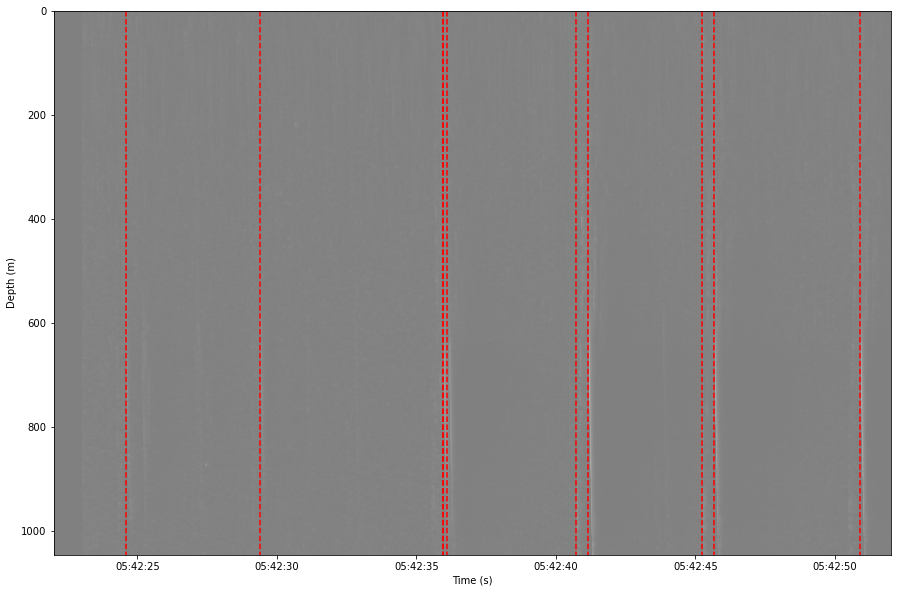

In [426]:
# try with coindence 
triggers = coincidence_trigger(None,5,3,st_stalta,25)
trigger_times = [trigger['time'] for trigger in triggers]

# plot detections
ax = plot_moveout(stalta_array,st_stalta,channels)
ax.vlines(trigger_times,ymin=0,ymax=spacing*(channels[-1]-channels[0]),colors="r",linestyles="--")
plt.show()

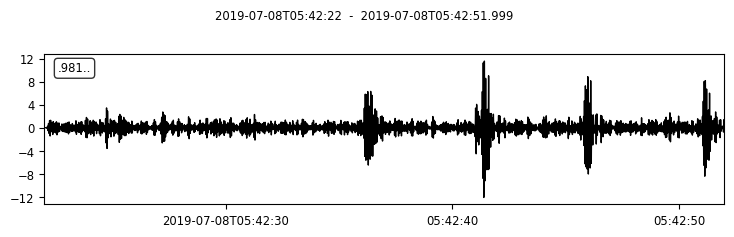

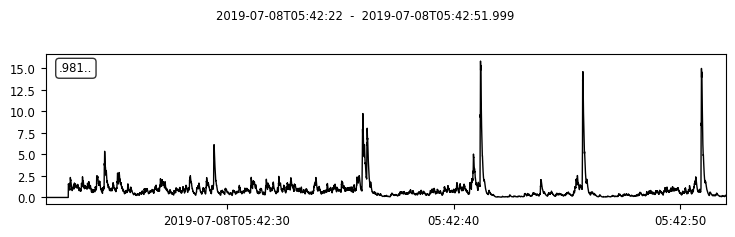

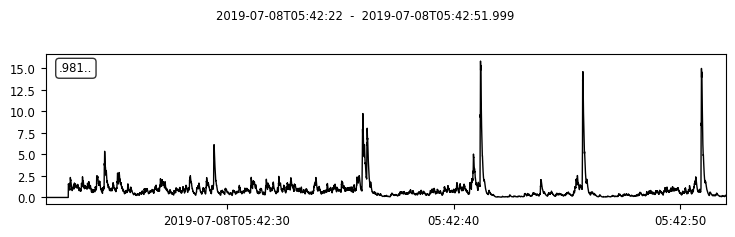

In [432]:
st.filter("bandpass",freqmin=10,freqmax=50)
st.select(station="981").plot();
st_stalta.select(station="981").plot()